For a give set of edges: 
- load edges file
- construct network
- do a bunch of excercises and calculations: 
    - cliques 



In [187]:
import pandas as pd
import networkx as nx
from networkx import centrality
from networkx.algorithms import clique
from networkx.algorithms import core
from networkx.algorithms import traversal
from networkx.algorithms import distance_measures
from networkx.algorithms import approximation
from networkx.algorithms import shortest_paths
from networkx.algorithms import bridges, has_bridges, local_bridges
from helpers import graph_search

In [188]:
# filename  = 'edges/example1.txt'
# filename = 'edges/week5_kcore.txt'
# filename = 'edges/at2_q1.txt'
# filename = 'edges/edge_betweeness_flow.txt'
# filename = 'edges/sample_exam_A2.txt'
filename = 'edges/isomorphism_g1.txt'

In [189]:
df_edges = pd.read_csv(filename, sep=':', header=None, names=['from', 'to_list'])
df_edges['to_list_split'] = df_edges.to_list.str.strip().str.split(',')
df_edges = df_edges.explode('to_list_split')
df_edges['from'] = df_edges['from'].astype('str')
# keep hold of nodes with no edges 
add_nodes = df_edges['from'][df_edges.to_list_split.isna()]
# drop incomplete edges 
df_edges.drop(list(add_nodes.index), inplace=True)
# list(df_edges[['from','to_list_split']].itertuples(index=False))
# [tuple(e) for i,e in df_edges[['from','to_list_split']].iterrows()]
# list(zip(df_edges['from'], df_edges['to_list_split']))
edges = [tuple(e) for e in df_edges[['from','to_list_split']].to_records(index=False)]

In [190]:
set(df_edges['to_list_split'].astype(df_edges['from'].dtype))

{'A', 'B', 'C', 'D', 'E'}

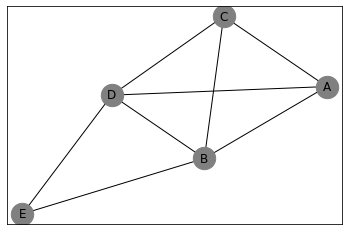

In [191]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from(add_nodes)

pos = nx.layout.spring_layout(G)
nx.draw_networkx(G, pos=pos, node_size=500, node_color='grey')

In [192]:
# print(nx.info(G))
network_properties = { 
    'nodes': G.order(), 
    'edges': G.size(),
    'average_degree': float(format(2 * G.size()/G.order(),'.3f')),
    'diameter': distance_measures.diameter(G), 
    'average_clustering_coefficient': approximation.average_clustering(G)
    }

for k,v in network_properties.items():
    print(k,v)

nodes 5
edges 8
average_degree 3.2
diameter 2
average_clustering_coefficient 0.843


In [193]:
def get_df(measure, column_name):
    return pd.DataFrame(dict(measure).items(), columns=['node', column_name])

def add_measure(df, measure,column_name): 
    temp = df.join(get_df(measure,column_name),lsuffix='',rsuffix='_r')
    return temp.drop(columns=temp.columns[temp.columns.str.endswith('_r')])

In [194]:
df_measures = pd.DataFrame(list(G.nodes()), columns=['node'])
df_measures

,node
0,A
1,B
2,C
3,D
4,E


# add measures 

* clustering coefficient 
* degree
* degree centrality 
* closenness cenrality 
* betweenness cenrality 

In [195]:
df_measures = add_measure(df_measures, nx.clustering(G), 'clustring')
df_measures = add_measure(df_measures, nx.degree(G), 'degree')
df_measures = add_measure(df_measures, centrality.degree_centrality(G), 'degree_centrality')
df_measures = add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')
df_measures['closeness_inv'] = 1/df_measures['closeness_centrality']
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=False), 'betweenness')
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=True), 'betweenness_centrality')
df_measures = add_measure(df_measures, core.core_number(G), 'core')


In [196]:
add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')

,node,clustring,degree,degree_centrality,closeness_centrality,closeness_inv,betweenness,betweenness_centrality,core
0,A,1.000000,3,0.75,0.800000,1.25,0.0,0.000000,3
1,B,0.666667,4,1.00,1.000000,1.00,1.0,0.166667,3
2,C,1.000000,3,0.75,0.800000,1.25,0.0,0.000000,3
3,D,0.666667,4,1.00,1.000000,1.00,1.0,0.166667,3
4,E,1.000000,2,0.50,0.666667,1.50,0.0,0.000000,2


The core number of a node is the largest value k of a k-core containing that node.

# find all cliques and maximal cliques 

In [197]:

maximal_cliques = [''.join(sorted(c)) for c in clique.find_cliques(G)]
print('maximal cliques')
print(maximal_cliques)

maximal cliques
['BDE', 'ABCD']


In [198]:
df_cliques = pd.DataFrame([(len(c), sorted(c), ''.join(sorted(c))) for c in clique.enumerate_all_cliques(G) if len(c) > 2], columns=['clique_size', 'clique_list', 'clique'])
df_cliques['maximal_clique'] = df_cliques.clique.isin(maximal_cliques)
df_cliques.query( "maximal_clique == True")

,clique_size,clique_list,clique,maximal_clique
4,3,"[B, D, E]",BDE,True
5,4,"[A, B, C, D]",ABCD,True


In [199]:
df_cliques.query('clique_size == 3')

,clique_size,clique_list,clique,maximal_clique
0,3,"[A, B, C]",ABC,False
1,3,"[A, B, D]",ABD,False
2,3,"[A, C, D]",ACD,False
3,3,"[B, C, D]",BCD,False
4,3,"[B, D, E]",BDE,True


# k-core

In [200]:
print('maximal k-core with k = ', max(df_measures.core), ': ', ''.join(sorted([k for k in core.k_core(G)])))

maximal k-core with k =  3 :  ABCD


In [201]:
k = 2
''.join(sorted(df_measures.query(f'core >= {k}')['node']))

'ABCDE'

In [202]:
[c for c in nx.isolates(G)]

[]

# network traversal: BFS and DFS

In [203]:
start_node = 'A'

In [204]:
print(f'BFS traversal start at {start_node}: ', ' '.join([b for b in traversal.bfs_tree(G, start_node)]))

BFS traversal start at A:  A B C D E


In [205]:
print(f'DFS traversal start at {start_node}: ', ' '.join([b for b in traversal.dfs_tree(G, start_node)]))

DFS traversal start at A:  A B C D E


Edge Betweenness 

In [206]:
[e for e in traversal.edge_bfs(G, 'A')]

[('A', 'B'),
 ('A', 'C'),
 ('A', 'D'),
 ('B', 'C'),
 ('B', 'D'),
 ('B', 'E'),
 ('C', 'D'),
 ('D', 'E')]

# shortest paths

In [207]:
nodes_list = list(G.nodes)

diameter = 0
diameter_path = None
all_shortest_paths = []
for i, start_n in enumerate(G.nodes): 
    print(i, start_n)
    nodes_list.pop(0) # remove current node from nodes list
    str = ""

    diameter_updated = False
    for j, target_n in enumerate(nodes_list):
        # shortest_path = nx.dijkstra_path(G, source=start_n, target=target_n)
        shortest_path = shortest_paths.all_shortest_paths(G, source=start_n, target=target_n)
        shortest_path = [''.join(sp) for sp in shortest_path]
        shortest_path_length = nx.dijkstra_path_length(G, source=start_n, target=target_n)
        # str = str + f"({j}, {target_n}, {'-'.join(shortest_path)}, {shortest_path_length})"
        all_shortest_paths.append((start_n, target_n, shortest_path, shortest_path_length, len(shortest_path)))
        if shortest_path_length > diameter:
            diameter = shortest_path_length
            diameter_path = shortest_path
            diameter_updated = True
    # print(str)
    print(f"{'update diameter' if diameter_updated else ''}")

shortest_paths_df = pd.DataFrame(all_shortest_paths, columns=['from', 'to', 'geodesic', 'length', 'count'])

0 A
update diameter
1 B

2 C

3 D

4 E



## potential local bridges

In [208]:
print('potential local bridges, if span > 2')
shortest_paths_df.query('length == 1')

potential local bridges, if span > 2


,from,to,geodesic,length,count
0,A,B,[AB],1,1
1,A,C,[AC],1,1
2,A,D,[AD],1,1
4,B,C,[BC],1,1
5,B,D,[BD],1,1
6,B,E,[BE],1,1
7,C,D,[CD],1,1
9,D,E,[DE],1,1


In [209]:
has_bridges(G)

False

In [210]:
# G_bridges = [b for b in bridges(G)]
df_local_bridges = pd.DataFrame([b for b in local_bridges(G)], columns=['from', 'to', 'span'])

## detecting bridges and local bridges 

definitins: 
* a-b is bridge -> graph disconnects if a-b is removed 
* a-b is local bridge -> there is another path between a-b with span > 2 and not other common connected nodes. 

`local_bridges()`: 

A local bridge is an edge whose endpoints have no common neighbors. That is, the edge is not part of a triangle in the graph.
The span of a local bridge is the shortest path length between the endpoints if the local bridge is removed.

in result of `local_bridges()`, if `span is inf`, then this global bridge, that is graph will disconnect if edge removed. 

In [211]:
print('local bridges, alternate span inf > means a bridge, will disconnect network if removed ')
print(df_local_bridges)

local bridges, alternate span inf > means a bridge, will disconnect network if removed 
Empty DataFrame
Columns: [from, to, span]
Index: []


# Isomorphism 

In [212]:
g2_filename = 'edges\isomorphism_g2.txt'
df_edges2 = pd.read_csv(g2_filename, sep=':', header=None, names=['from', 'to_list'])
df_edges2['to_list_split'] = df_edges2.to_list.str.strip().str.split(',')
df_edges2 = df_edges2.explode('to_list_split')
df_edges2['from'] = df_edges2['from'].astype('str')
add_nodes2 = df_edges2['from'][df_edges2.to_list_split.isna()]
df_edges2.drop(list(add_nodes2.index), inplace=True)
edges2 = [tuple(e) for e in df_edges2[['from','to_list_split']].to_records(index=False)]
G2 = nx.Graph()
G2.add_edges_from(edges2)
G2.add_nodes_from(add_nodes2)

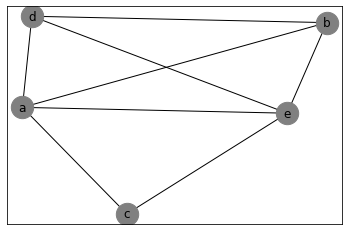

In [213]:

pos2 = nx.layout.spring_layout(G2)
nx.draw_networkx(G2, pos=pos2, node_size=500, node_color='grey')

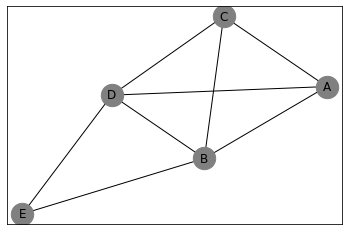

In [214]:
nx.draw_networkx(G, pos=pos, node_size=500, node_color='grey')

In [221]:
from networkx.algorithms import isomorphism

print('could be isomorphic: ', isomorphism.could_be_isomorphic(G,G2))

could be isomorphic:  True


In [223]:
GM = isomorphism.GraphMatcher(G, G2)
GM.is_isomorphic()

True

In [227]:
pd.DataFrame(GM.mapping.items(), columns={'G', 'G1'}).sort_values(by='G')

,G,G1
1,A,b
0,B,a
3,C,d
2,D,e
4,E,c


In [216]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 8
Average degree:   3.2000


In [217]:
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 8
Average degree:   3.2000


In [218]:
[e for e in G.edges()]

[('A', 'B'),
 ('A', 'C'),
 ('A', 'D'),
 ('B', 'C'),
 ('B', 'D'),
 ('B', 'E'),
 ('C', 'D'),
 ('D', 'E')]

In [219]:
[e for e in G2.edges()]

[('a', 'b'),
 ('a', 'e'),
 ('a', 'd'),
 ('a', 'c'),
 ('b', 'd'),
 ('b', 'e'),
 ('e', 'c'),
 ('e', 'd')]